# LUNA Basic Tutorial #2 - Generating fingerprints and running multiple jobs

This tutorial will cover: 
* Running multiple jobs sequentially vs in parallel
* Generate different flavors of IFP and convert them to RDKit-like objects and then compute Tanimoto similarity
* Plotting heatmaps for summarizing the interactions
* Plotting a Pymol session for superposed complexes

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import os

### Set up system paths and import LUNA

In [2]:
LUNApath = '/srv/home/lshub/LUNA' #change this to point to LUNA directory

import sys
sys.path.append(LUNApath)

import luna

RDKit WARNING: [13:14:15] Enabling RDKit 2019.09.3 jupyter extensions
/srv/home/lshub/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


**<ins>NOTE:</ins> in luna/util/default_values.py, change the OPENBABEL default location from 
    "/usr/bin/obabel" to location of obabel executable**

### Setting up entries and PDB folder

In [3]:
from luna.mol.entry import MolEntry

In [4]:
input_path = "./inputs"
output_path = "./multilig-outputs"

In [5]:
!ls "./inputs/"

3QQK.pdb	 ZINC000007786517.mol  ZINC000357551804.mol
all_ligands.mol  ZINC000113177982.mol  ZINC000661525536.mol
D4.pdb		 ZINC000348555593.mol


#### Note: These entries all use the same receptor pdb file. If you have different pdb files for each ligand, make sure to define each entry with the correct corresponding pdb name.

In [6]:
zinc_ids = [lig.strip('.mol') for lig in os.listdir(input_path) \
            if "ZINC" in lig]

In [7]:
entries = []
for lig in zinc_ids:
    entry = MolEntry.from_mol_file("D4", lig, f"./inputs/{lig}.mol", 
                mol_obj_type='rdkit', is_multimol_file=False)
    entries.append(entry)

### Calculating interaction fingerprints

#### Setting up parameters

In [8]:
opt = {}

opt['entries'] = entries
opt['working_path'] = output_path
opt['pdb_path'] = input_path

opt['overwrite_path'] = False
opt['try_h_addition'] = False
opt['ph'] = 7.4
opt['amend_mol'] = False

opt['mol_obj_type'] = 'rdkit'
opt['verbosity'] = 2 # How verbose is the logger

In [9]:
from luna.mol.interaction.filter import InteractionFilter
from luna.mol.interaction.calc import InteractionCalculator

In [10]:
pli_filter = InteractionFilter.new_pli_filter()
opt['inter_calc'] = InteractionCalculator(inter_filter=pli_filter)

### Fingerprint options

In [11]:
from luna.mol.interaction.fp.type import IFPType

In [12]:
opt['calc_mfp'] = False #molecular fingerprint
opt['calc_ifp'] = True #interaction fingerprint

opt['ifp_type'] = IFPType.EIFP #type of fingerprints: EIFP or FIFP
opt['ifp_count'] = True #choose between count and bit fingerprint

opt["ifp_num_levels"] = 6 # IFP parameter: number of levels
opt["ifp_radius_step"] = 2 # IFP parameter: radius growth
opt["ifp_length"] = 4096 # IFP parameter: size of the fingerprint

### Determine how many processes to run in parallel

By default, jobs are run in parallel, with up to NPROC simultaneous processes. NPROC depends on the CPU count of your current system.

In [13]:
print(f"Current nproc: {mp.cpu_count() - 1}")

Current nproc: 39


Setting NPROC to "None" forces jobs to be run sequentially

In [14]:
proj_obj = luna.projects.LocalProject(**opt, 
                                      nproc = None) #define only 1 process at a time
start_time = time.time()
proj_obj.run()
end_time = time.time()

[2021-06-08 13:14:18]    INFO            projects.py:308        LUNA version: 0.9.0.
[2021-06-08 13:14:18]    INFO            projects.py:308        Verbosity set to: 2 (WARNING).
[2021-06-08 13:14:18]    WARNING         projects.py:308        The number of processes was set to 'None'. Therefore, LUNA will run jobs sequentially.
[2021-06-08 13:14:18]    INFO            projects.py:308        Preparing project directory './multilig-outputs'.
[2021-06-08 13:14:18]    INFO                file.py:102        The directory './multilig-outputs/results' already exists, but it will not be cleared.
[2021-06-08 13:14:18]    INFO            projects.py:308        Project directory './multilig-outputs' created successfully.


/srv/home/lshub/LUNA/luna/projects.py:270: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2021-06-08 13:16:23]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 25.06s/task; Errors: 0] - Entries processing.


In [15]:
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 125.95805239677429 seconds


Increases nproc allows ligands to run in parallel

In [16]:
proj_obj = luna.projects.LocalProject(**opt)
start_time = time.time()
proj_obj.run()
end_time = time.time()

/srv/home/lshub/LUNA/luna/projects.py:270: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2021-06-08 13:16:47]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 22.35s/task; Errors: 0] - Entries processing.


In [17]:
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 23.977506637573242 seconds


### Evaluate results

The results for each individual entry can be accessed through the EntryResult.

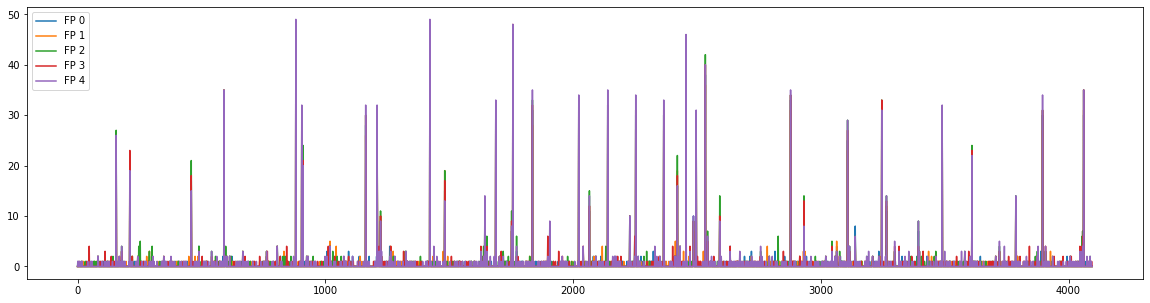

In [18]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, entry in enumerate(entries):
    fp = proj_obj.get_entry_results(entry).ifp
    plot_vals = [fp.counts[i] if i in fp.counts else 0 for i in range(1, fp.fp_length + 1)]
    ax.plot(plot_vals, label = f"FP {i}")
plt.legend()

### Bit fingerprints

In [19]:
opt['ifp_count'] = True #choose between count and bit fingerprint
proj_obj = luna.projects.LocalProject(**opt)
proj_obj()

/srv/home/lshub/LUNA/luna/projects.py:270: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


[2021-06-08 13:17:09]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 19.77s/task; Errors: 0] - Entries processing.


#### Density - how populated is the fingerprint

(array([1., 0., 1., 2., 0., 0., 0., 0., 0., 1.]),
 array([0.09838867, 0.10266113, 0.10693359, 0.11120605, 0.11547852,
        0.11975098, 0.12402344, 0.1282959 , 0.13256836, 0.13684082,
        0.14111328]),
 <a list of 10 Patch objects>)

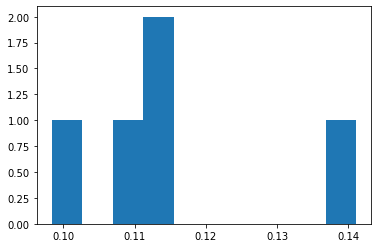

In [20]:
densities = [proj_obj.get_entry_results(entry).ifp.density for entry in entries]
plt.hist(densities)

#### Tanimoto coefficient - how similar are two fingerprints

In [21]:
def tanimoto(fp1, fp2):
    id1, id2 = set(fp1.indices), set(fp2.indices)
    i = id1.intersection(id2)
    u = id1.union(id2)
    return float(len(i))/len(u)

(array([1., 0., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([0.21077283, 0.21473194, 0.21869105, 0.22265015, 0.22660926,
        0.23056837, 0.23452747, 0.23848658, 0.24244569, 0.24640479,
        0.2503639 ]),
 <a list of 10 Patch objects>)

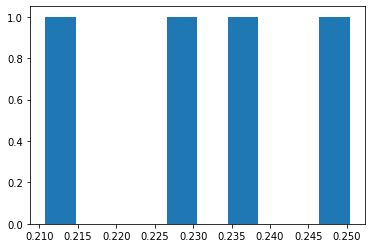

In [22]:
tanimotos = [tanimoto(proj_obj.get_entry_results(entries[0]).ifp, proj_obj.get_entry_results(entries[i]).ifp) 
             for i in range(1,5)]
plt.hist(tanimotos)

### Plotting interaction heatmaps

In [23]:
from luna.analysis.residues import calculate_residues_frequency
from luna.analysis.view import res_freq_heatmap

In [24]:
interaction_tuples = [(entry, proj_obj.get_entry_results(entry).interactions_mngr) for entry in entries]

In [25]:
rf = calculate_residues_frequency(interaction_tuples)

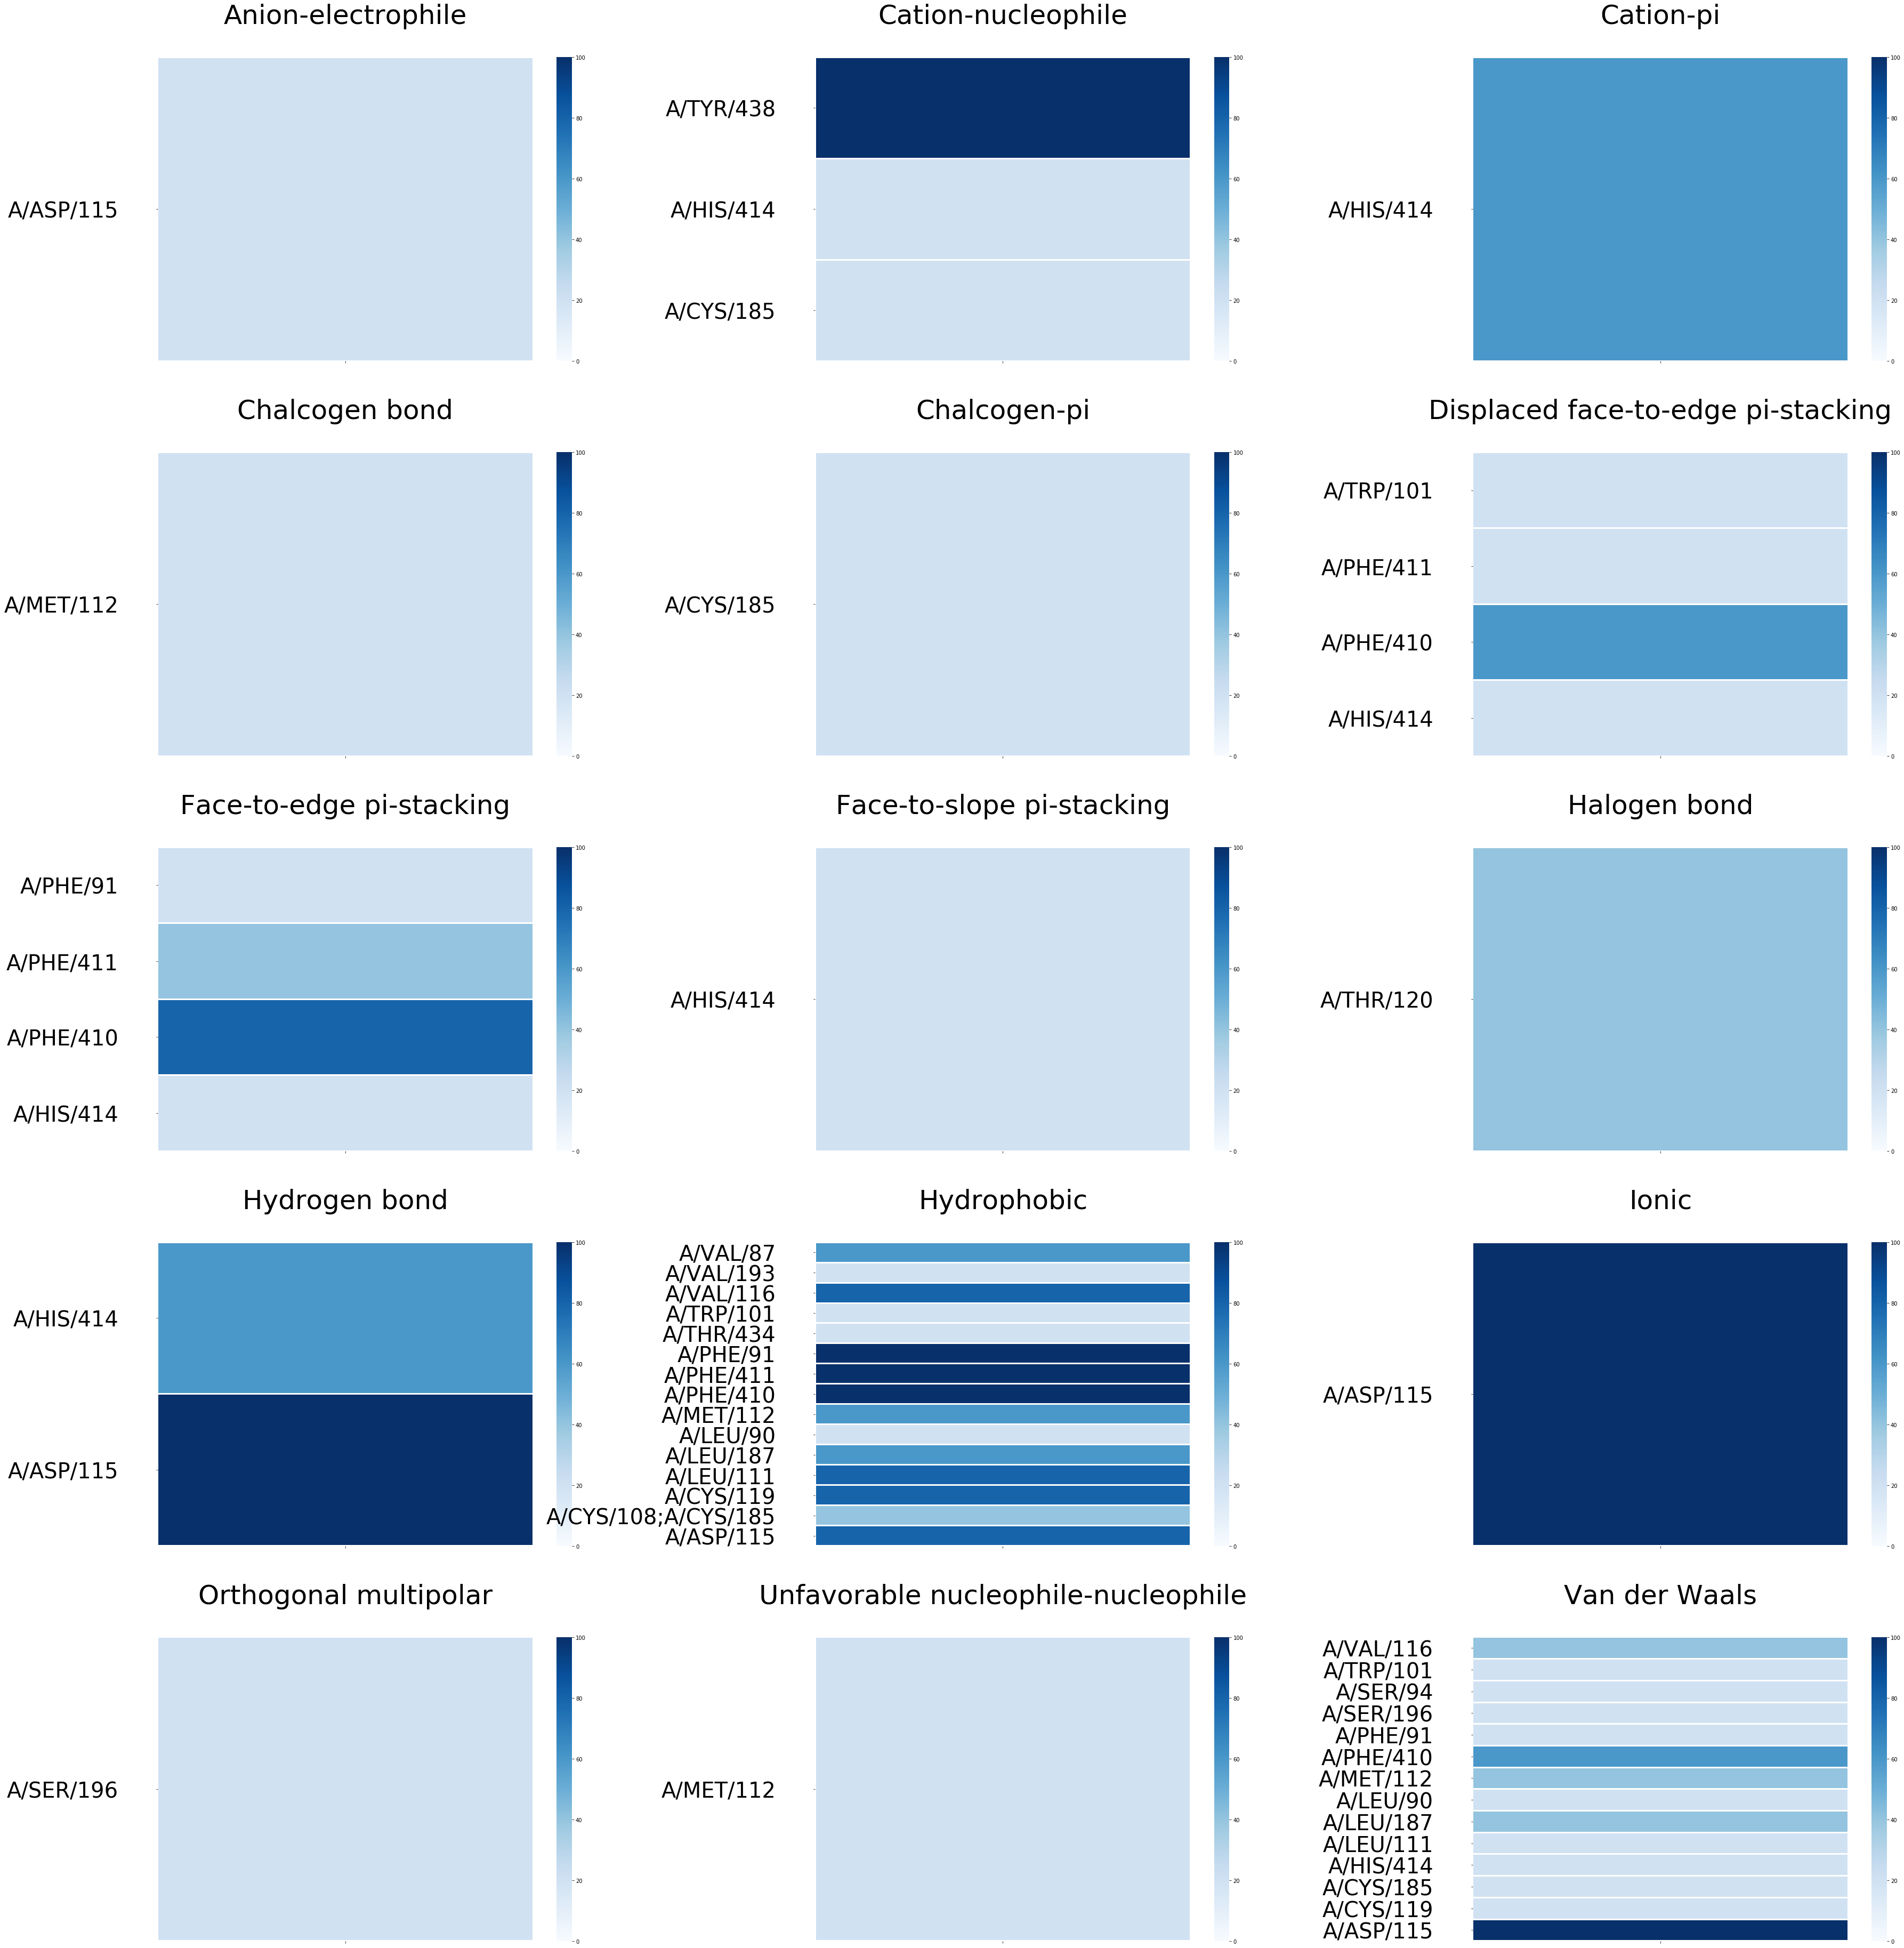

In [26]:
res_freq_heatmap(len(entries), rf, 'test')

## Plotting multiple pymol sessions

In [27]:
from luna.mol.interaction.view import InteractionViewer

In [28]:
for entry in entries:
    entry.pdb_file = "./inputs/D4.pdb"

In [29]:
all_tuples = [(entry, proj_obj.get_entry_results(entry).interactions_mngr) for entry in entries]
pse_file = "./multilig-outputs/multilig-visualization-all.pse"

inter_view = InteractionViewer()
inter_view.new_session(all_tuples, pse_file)

 PyMOL not running, entering library mode (experimental)
 Applying pse_export_version=1.800 compatibility
